In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

c:\Users\danny\anaconda3\envs\py310\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Using device: cuda


## 1. Load and Preprocess Data

In [2]:
# Load Data
print("Loading data...")
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Preprocessing
for df in [train_df, test_df]:
    df['time_stamp'] = pd.to_datetime(df['time_stamp'], format='mixed')
    df['total_seconds'] = df['time_stamp'].astype('int64')
    
train_df = train_df.sort_values(['traj_ind', 'total_seconds'])
test_df = test_df.sort_values(['traj_ind', 'total_seconds'])

# Add kinematics
def add_kinematics(df):
    dt = df.groupby('traj_ind')['time_stamp'].diff().dt.total_seconds()
    dx = df.groupby('traj_ind')['x'].diff()
    dy = df.groupby('traj_ind')['y'].diff()
    dz = df.groupby('traj_ind')['z'].diff()
    
    df['v_x'] = dx / dt
    df['v_y'] = dy / dt
    df['v_z'] = dz / dt
    df['speed'] = (df['v_x']**2 + df['v_y']**2 + df['v_z']**2)**0.5
    df['step_dist'] = (dx**2 + dy**2 + dz**2)**0.5
    return df

train_df = add_kinematics(train_df)
test_df = add_kinematics(test_df)
print(f"Train: {len(train_df)} points, Test: {len(test_df)} points")

Loading data...


Train: 1021976 points, Test: 253393 points


## 2. Feature Extraction (Same as RF)

In [3]:
def extract_trajectory_features(df):
    """Extract scalar aggregated features per trajectory."""
    print("Extracting scalar features...")
    grp = df.groupby('traj_ind')
    
    aggs = grp.agg({
        'x': ['first', 'last', 'min', 'max', 'mean', 'std'],
        'y': ['first', 'last', 'min', 'max', 'mean', 'std'],
        'z': ['first', 'last', 'min', 'max', 'mean', 'std'],
        'total_seconds': ['first', 'last', 'count'],
        'speed': ['first', 'mean', 'max', 'std'], 
        'v_x': ['first', 'mean', 'std'], 
        'v_y': ['first', 'mean', 'std'], 
        'v_z': ['first', 'mean', 'std'], 
        'step_dist': ['sum']
    })
    aggs.columns = ['_'.join(col).strip() for col in aggs.columns.values]
    
    # Derived features
    aggs['duration'] = aggs['total_seconds_last'] - aggs['total_seconds_first']
    aggs['dist_start_end'] = np.sqrt(
        (aggs['x_last'] - aggs['x_first'])**2 + 
        (aggs['y_last'] - aggs['y_first'])**2 + 
        (aggs['z_last'] - aggs['z_first'])**2
    )
    aggs['straightness'] = aggs['dist_start_end'] / aggs['step_dist_sum']
    
    # Launch angles
    vx = aggs['v_x_first'].fillna(0)
    vy = aggs['v_y_first'].fillna(0)
    vz = aggs['v_z_first'].fillna(0)
    aggs['launch_azimuth'] = np.arctan2(vy, vx)
    aggs['launch_elevation'] = np.arctan2(vz, np.sqrt(vx**2 + vy**2))
    
    aggs.replace([np.inf, -np.inf], 0, inplace=True)
    aggs = aggs.fillna(0)
    return aggs

def extract_physics_features(df):
    """Extract parabolic fit coefficients."""
    print("Extracting physics features...")
    features = []
    indices = []
    
    for traj_id, group in df.groupby('traj_ind'):
        t_ns = group['total_seconds'].values
        t = (t_ns - t_ns[0]) / 1e9
        
        x, y, z = group['x'].values, group['y'].values, group['z'].values
        vx = group['v_x'].fillna(method='bfill').fillna(0).values
        vy = group['v_y'].fillna(method='bfill').fillna(0).values
        vz = group['v_z'].fillna(method='bfill').fillna(0).values
        
        row = {}
        
        # Position parabolic fit
        if len(t) >= 3:
            try:
                for axis, data in zip(['x', 'y', 'z'], [x, y, z]):
                    c, res, _, _, _ = np.polyfit(t, data, 2, full=True)
                    row[f'c{axis}_2'], row[f'c{axis}_1'], row[f'c{axis}_0'] = c
                    row[f'res_{axis}'] = res[0] if len(res) > 0 else 0.0
            except:
                for axis in ['x', 'y', 'z']:
                    row[f'c{axis}_2'] = row[f'c{axis}_1'] = row[f'c{axis}_0'] = row[f'res_{axis}'] = 0
        else:
            for axis in ['x', 'y', 'z']:
                row[f'c{axis}_2'] = row[f'c{axis}_1'] = row[f'c{axis}_0'] = row[f'res_{axis}'] = 0
        
        # Velocity linear fit (acceleration)
        if len(t) >= 2:
            try:
                t_r = t.reshape(-1, 1)
                for axis, data in zip(['x', 'y', 'z'], [vx, vy, vz]):
                    m = LinearRegression().fit(t_r, data)
                    row[f'acc_{axis}'] = m.coef_[0]
                    row[f'v0_fit_{axis}'] = m.intercept_
            except:
                for axis in ['x', 'y', 'z']:
                    row[f'acc_{axis}'] = row[f'v0_fit_{axis}'] = 0
        else:
            for axis in ['x', 'y', 'z']:
                row[f'acc_{axis}'] = row[f'v0_fit_{axis}'] = 0
        
        features.append(row)
        indices.append(traj_id)
    
    return pd.DataFrame(features, index=indices)

# Extract features
X_train_scalar = extract_trajectory_features(train_df)
X_test_scalar = extract_trajectory_features(test_df)
X_train_phys = extract_physics_features(train_df)
X_test_phys = extract_physics_features(test_df)

# Combine
X_train_full = pd.concat([X_train_scalar, X_train_phys], axis=1)
X_test_full = pd.concat([X_test_scalar, X_test_phys], axis=1)

# Labels
y_train = train_df.groupby('traj_ind')['label'].first().loc[X_train_full.index]

print(f"Features shape: {X_train_full.shape}")
print(f"Class distribution: {dict(Counter(y_train))}")

Extracting scalar features...
Extracting scalar features...
Extracting physics features...
Extracting physics features...
Features shape: (32741, 58)
Class distribution: {1: 7940, 0: 22462, 2: 2339}


## 3. Create Barrage Sequences

Group trajectories into barrages (continuous time windows from same location).
Each barrage becomes a **sequence** that the Transformer will process.

In [4]:
def create_barrage_sequences(X_df, y_series=None, time_threshold_min=5):
    """
    Group trajectories into barrage sequences.
    Each barrage is a sequence of trajectories from the same location within time_threshold.
    """
    print("Creating barrage sequences...")
    df = X_df.copy()
    
    # Sort by location and time
    df = df.sort_values(['x_first', 'y_first', 'z_first', 'total_seconds_first'])
    
    # Identify barrages
    TIME_THRESHOLD_NS = time_threshold_min * 60 * 1_000_000_000
    grp_cols = ['x_first', 'y_first', 'z_first']
    df['time_diff'] = df.groupby(grp_cols)['total_seconds_first'].diff()
    df['new_barrage'] = (df['time_diff'].isna()) | (df['time_diff'] > TIME_THRESHOLD_NS)
    df['barrage_id'] = df['new_barrage'].cumsum()
    
    # Select feature columns (exclude metadata)
    feature_cols = [c for c in df.columns if c not in 
                    ['time_diff', 'new_barrage', 'barrage_id', 'total_seconds_first', 'total_seconds_last']]
    
    # Group into sequences
    sequences = []
    labels_seq = []
    traj_indices = []
    barrage_ids = []
    
    for barrage_id, group in df.groupby('barrage_id'):
        # Sort by time within barrage
        group = group.sort_values('total_seconds_first')
        
        seq_features = group[feature_cols].values.astype(np.float32)
        seq_traj_idx = group.index.tolist()
        
        sequences.append(seq_features)
        traj_indices.append(seq_traj_idx)
        barrage_ids.append(barrage_id)
        
        if y_series is not None:
            seq_labels = y_series.loc[group.index].values.astype(np.int64)
            labels_seq.append(seq_labels)
    
    print(f"Created {len(sequences)} barrage sequences")
    print(f"Sequence lengths: min={min(len(s) for s in sequences)}, "
          f"max={max(len(s) for s in sequences)}, "
          f"mean={np.mean([len(s) for s in sequences]):.1f}")
    
    if y_series is not None:
        return sequences, labels_seq, traj_indices, barrage_ids, feature_cols
    return sequences, traj_indices, barrage_ids, feature_cols

# Create sequences
train_seqs, train_labels, train_traj_idx, train_barrage_ids, feature_cols = \
    create_barrage_sequences(X_train_full, y_train)
test_seqs, test_traj_idx, test_barrage_ids, _ = \
    create_barrage_sequences(X_test_full)

print(f"\nFeature dimension: {len(feature_cols)}")

Creating barrage sequences...


Created 8016 barrage sequences
Sequence lengths: min=2, max=6, mean=4.1
Creating barrage sequences...
Created 1985 barrage sequences
Sequence lengths: min=2, max=6, mean=4.1

Feature dimension: 56


## 4. Transformer Model Architecture

The model uses **self-attention** to let each trajectory see all other trajectories in the barrage.
This way, each prediction is informed by the "whole picture".

In [5]:
class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding to preserve sequence order."""
    def __init__(self, d_model, max_len=500, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # x: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class BarrageTransformer(nn.Module):
    """
    Transformer for barrage-level sequence classification.
    
    Key features:
    - Self-attention allows each trajectory to attend to ALL other trajectories
    - Each position gets a classification that considers the full barrage context
    - Positional encoding preserves temporal order within the barrage
    """
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=4, 
                 dim_feedforward=256, num_classes=3, dropout=0.2, max_len=500):
        super().__init__()
        
        self.d_model = d_model
        
        # Input projection: features -> transformer dimension
        self.input_projection = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, max_len, dropout)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True  # Pre-norm for better training stability
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Classification head (per position)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, x, src_key_padding_mask=None):
        """
        Args:
            x: (batch, seq_len, input_dim) - input features
            src_key_padding_mask: (batch, seq_len) - True for padding positions
            
        Returns:
            logits: (batch, seq_len, num_classes) - per-position predictions
        """
        # Project input
        x = self.input_projection(x)  # (batch, seq_len, d_model)
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # Transformer encoder (self-attention across all positions)
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        
        # Classify each position
        logits = self.classifier(x)  # (batch, seq_len, num_classes)
        
        return logits


print("Transformer model defined.")
print("\nKey insight: Self-attention lets each trajectory 'see' all other")
print("trajectories in the barrage, so predictions consider the full context.")

Transformer model defined.

Key insight: Self-attention lets each trajectory 'see' all other
trajectories in the barrage, so predictions consider the full context.


## 5. Dataset and DataLoader

In [6]:
class BarrageDataset(Dataset):
    def __init__(self, sequences, labels=None, scaler=None, fit_scaler=False):
        self.sequences = sequences
        self.labels = labels
        
        # Normalize features
        if fit_scaler:
            all_data = np.vstack(sequences)
            self.scaler = StandardScaler()
            self.scaler.fit(all_data)
        else:
            self.scaler = scaler
        
        # Apply scaling
        self.scaled_seqs = []
        for seq in sequences:
            scaled = self.scaler.transform(seq)
            scaled = np.nan_to_num(scaled, nan=0.0, posinf=0.0, neginf=0.0)
            self.scaled_seqs.append(scaled)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = torch.tensor(self.scaled_seqs[idx], dtype=torch.float32)
        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return seq, label
        return seq


def collate_fn(batch):
    """Pad sequences and create attention masks."""
    if isinstance(batch[0], tuple):
        seqs, labels = zip(*batch)
        lengths = [len(s) for s in seqs]
        max_len = max(lengths)
        
        # Pad sequences
        seqs_padded = pad_sequence(seqs, batch_first=True, padding_value=0)
        labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)
        
        # Create padding mask (True = padding, False = real data)
        padding_mask = torch.zeros(len(seqs), max_len, dtype=torch.bool)
        for i, length in enumerate(lengths):
            padding_mask[i, length:] = True
        
        return seqs_padded, labels_padded, padding_mask, torch.tensor(lengths)
    else:
        seqs = batch
        lengths = [len(s) for s in seqs]
        max_len = max(lengths)
        
        seqs_padded = pad_sequence(seqs, batch_first=True, padding_value=0)
        padding_mask = torch.zeros(len(seqs), max_len, dtype=torch.bool)
        for i, length in enumerate(lengths):
            padding_mask[i, length:] = True
        
        return seqs_padded, padding_mask, torch.tensor(lengths)


print("Dataset and collate function defined.")

Dataset and collate function defined.


## 6. Training Setup (Leak-Proof Split)

In [7]:
from sklearn.model_selection import GroupKFold
from imblearn.over_sampling import RandomOverSampler

# Split by barrage (keep barrages together)
n_barrages = len(train_seqs)
barrage_indices = list(range(n_barrages))

# Get majority label for each barrage (for stratification)
barrage_majority_labels = [Counter(labels).most_common(1)[0][0] for labels in train_labels]

# Simple train/val split by barrage
train_bar_idx, val_bar_idx = train_test_split(
    barrage_indices, test_size=0.2, random_state=42,
    stratify=barrage_majority_labels
)

# Split sequences
train_seqs_split = [train_seqs[i] for i in train_bar_idx]
train_labels_split = [train_labels[i] for i in train_bar_idx]
val_seqs_split = [train_seqs[i] for i in val_bar_idx]
val_labels_split = [train_labels[i] for i in val_bar_idx]

print(f"Train barrages: {len(train_seqs_split)}")
print(f"Val barrages: {len(val_seqs_split)}")

# Count labels
train_label_counts = Counter(np.concatenate(train_labels_split))
val_label_counts = Counter(np.concatenate(val_labels_split))
print(f"\nTrain labels: {dict(train_label_counts)}")
print(f"Val labels: {dict(val_label_counts)}")

Train barrages: 6412
Val barrages: 1604

Train labels: {0: 17939, 1: 6353, 2: 1862}
Val labels: {1: 1587, 0: 4523, 2: 477}


In [ ]:
# Create datasets
train_dataset = BarrageDataset(train_seqs_split, train_labels_split, fit_scaler=True)
val_dataset = BarrageDataset(val_seqs_split, val_labels_split, scaler=train_dataset.scaler)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Calculate class weights for imbalanced data
all_train_labels = np.concatenate(train_labels_split)
class_counts = np.bincount(all_train_labels)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_weights)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(f"Class weights: {class_weights}")

Class weights: tensor([0.2229, 0.6294, 2.1476], device='cuda:0')


In [17]:
train_dataset[11][0].shape

torch.Size([5, 56])

## 7. Initialize Model

In [9]:
# Model hyperparameters
input_dim = len(feature_cols)
d_model = 128
nhead = 8
num_layers = 4
dim_feedforward = 256
dropout = 0.2

model = BarrageTransformer(
    input_dim=input_dim,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    num_classes=3,
    dropout=dropout
)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=-100)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Input dimension: {input_dim}")
print(f"Model dimension: {d_model}")
print(f"Attention heads: {nhead}")
print(f"Transformer layers: {num_layers}")

Model parameters: 545,923
Input dimension: 56
Model dimension: 128
Attention heads: 8
Transformer layers: 4


## 8. Training Loop

In [10]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    
    for seqs, labels, padding_mask, lengths in loader:
        seqs = seqs.to(device)
        labels = labels.to(device)
        padding_mask = padding_mask.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(seqs, src_key_padding_mask=padding_mask)
        
        # Compute loss
        logits_flat = logits.view(-1, 3)
        labels_flat = labels.view(-1)
        loss = criterion(logits_flat, labels_flat)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)


def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for seqs, labels, padding_mask, lengths in loader:
            seqs = seqs.to(device)
            labels = labels.to(device)
            padding_mask = padding_mask.to(device)
            
            logits = model(seqs, src_key_padding_mask=padding_mask)
            
            logits_flat = logits.view(-1, 3)
            labels_flat = labels.view(-1)
            loss = criterion(logits_flat, labels_flat)
            total_loss += loss.item()
            
            preds = logits.argmax(dim=-1)
            
            # Collect valid predictions
            for i in range(len(lengths)):
                seq_len = lengths[i].item()
                all_preds.extend(preds[i, :seq_len].cpu().numpy())
                all_labels.extend(labels[i, :seq_len].cpu().numpy())
    
    return total_loss / len(loader), np.array(all_preds), np.array(all_labels)


print("Training functions defined.")

Training functions defined.


In [18]:
# Training loop
num_epochs = 50
best_min_recall = 0
best_model_state = None
patience = 10
patience_counter = 0

print("Training Transformer model...")
print("=" * 80)

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_preds, val_labels = evaluate(model, val_loader, criterion)
    scheduler.step()
    
    # Calculate recalls
    recalls = recall_score(val_labels, val_preds, average=None, labels=[0, 1, 2])
    min_recall = min(recalls)
    
    # Print progress
    if epoch % 5 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch+1:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Recalls: [{recalls[0]:.3f}, {recalls[1]:.3f}, {recalls[2]:.3f}] | Min: {min_recall:.3f}")
    
    # Save best model (by min recall)
    if min_recall > best_min_recall:
        best_min_recall = min_recall
        best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
print(f"\nLoaded best model with min recall: {best_min_recall:.4f}")

Training Transformer model...
Epoch   1 | Train Loss: 0.3402 | Val Loss: 0.1849 | Recalls: [0.944, 0.882, 0.981] | Min: 0.882
Epoch   6 | Train Loss: 0.2220 | Val Loss: 0.1709 | Recalls: [0.952, 0.903, 0.990] | Min: 0.903
Epoch  11 | Train Loss: 0.2322 | Val Loss: 0.1519 | Recalls: [0.953, 0.911, 0.977] | Min: 0.911
Epoch  16 | Train Loss: 0.1762 | Val Loss: 0.1569 | Recalls: [0.963, 0.917, 0.971] | Min: 0.917
Epoch  21 | Train Loss: 0.1530 | Val Loss: 0.1585 | Recalls: [0.950, 0.937, 0.975] | Min: 0.937
Epoch  26 | Train Loss: 0.1448 | Val Loss: 0.1528 | Recalls: [0.957, 0.933, 0.973] | Min: 0.933

Early stopping at epoch 29

Loaded best model with min recall: 0.9452


## 9. Final Evaluation

In [19]:
# Final evaluation
val_loss, val_preds, val_labels = evaluate(model, val_loader, criterion)

print("=" * 80)
print("TRANSFORMER MODEL - FINAL VALIDATION RESULTS")
print("=" * 80)
print(classification_report(val_labels, val_preds, target_names=['Label 0', 'Label 1', 'Label 2']))

print("\nConfusion Matrix:")
cm = confusion_matrix(val_labels, val_preds)
print(pd.DataFrame(cm, 
                   index=['True 0', 'True 1', 'True 2'],
                   columns=['Pred 0', 'Pred 1', 'Pred 2']))

final_recalls = recall_score(val_labels, val_preds, average=None, labels=[0, 1, 2])
print(f"\nPer-class Recalls: Label 0={final_recalls[0]:.4f}, Label 1={final_recalls[1]:.4f}, Label 2={final_recalls[2]:.4f}")
print(f"Minimum Recall: {min(final_recalls):.4f}")

TRANSFORMER MODEL - FINAL VALIDATION RESULTS
              precision    recall  f1-score   support

     Label 0       0.99      0.95      0.97      4523
     Label 1       0.85      0.95      0.90      1587
     Label 2       0.96      0.95      0.96       477

    accuracy                           0.95      6587
   macro avg       0.93      0.95      0.94      6587
weighted avg       0.95      0.95      0.95      6587


Confusion Matrix:
        Pred 0  Pred 1  Pred 2
True 0    4275     245       3
True 1      58    1513      16
True 2       0      23     454

Per-class Recalls: Label 0=0.9452, Label 1=0.9534, Label 2=0.9518
Minimum Recall: 0.9452


## 10. Visualize Attention (Optional)

This shows how much each trajectory "attends to" other trajectories in the barrage.

Visualizing barrage 1 with 6 trajectories
Labels in this barrage: [1 1 1 1 1 1]


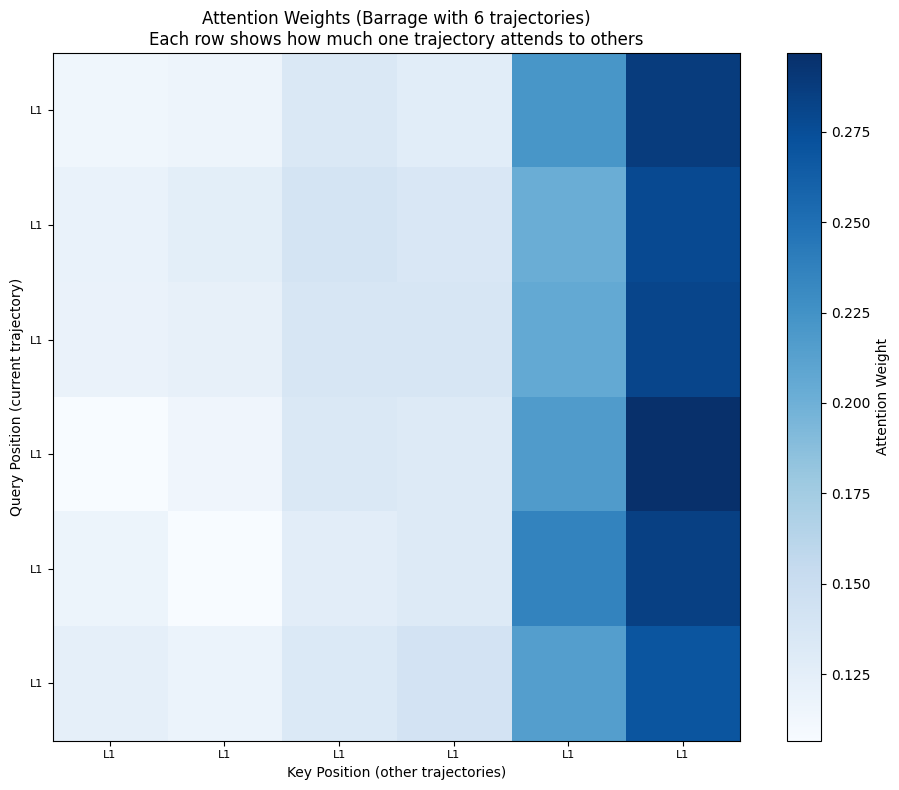

In [20]:
import matplotlib.pyplot as plt

def visualize_attention(model, dataset, sample_idx=0):
    """Visualize attention weights for a sample barrage."""
    model.eval()
    
    # Get sample
    if isinstance(dataset[sample_idx], tuple):
        seq, labels = dataset[sample_idx]
    else:
        seq = dataset[sample_idx]
        labels = None
    
    seq = seq.unsqueeze(0).to(device)  # (1, seq_len, features)
    seq_len = seq.shape[1]
    
    # Get attention weights from first layer
    with torch.no_grad():
        # Project input
        x = model.input_projection(seq)
        x = model.pos_encoder(x)
        
        # Get attention from first layer
        layer = model.transformer_encoder.layers[0]
        # Self attention
        attn_output, attn_weights = layer.self_attn(
            x, x, x, need_weights=True, average_attn_weights=True
        )
    
    attn = attn_weights[0].cpu().numpy()  # (seq_len, seq_len)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(attn, cmap='Blues')
    ax.set_xlabel('Key Position (other trajectories)')
    ax.set_ylabel('Query Position (current trajectory)')
    ax.set_title(f'Attention Weights (Barrage with {seq_len} trajectories)\n'
                 'Each row shows how much one trajectory attends to others')
    plt.colorbar(im, ax=ax, label='Attention Weight')
    
    if labels is not None:
        labels_np = labels.numpy()
        ax.set_xticks(range(seq_len))
        ax.set_yticks(range(seq_len))
        ax.set_xticklabels([f'L{l}' for l in labels_np], fontsize=8)
        ax.set_yticklabels([f'L{l}' for l in labels_np], fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return attn

# Find a barrage with multiple trajectories for visualization
for i, (seq, labels) in enumerate(val_dataset):
    if len(seq) >= 5 and len(seq) <= 20:  # Medium-sized barrage
        print(f"Visualizing barrage {i} with {len(seq)} trajectories")
        print(f"Labels in this barrage: {labels.numpy()}")
        attn = visualize_attention(model, val_dataset, i)
        break

## 11. Generate Test Submission

In [ ]:
# Create test dataset
test_dataset = BarrageDataset(test_seqs, scaler=train_dataset.scaler)

def collate_fn_test(batch):
    seqs = batch
    lengths = [len(s) for s in seqs]
    max_len = max(lengths)
    
    seqs_padded = pad_sequence(seqs, batch_first=True, padding_value=0)
    padding_mask = torch.zeros(len(seqs), max_len, dtype=torch.bool)
    for i, length in enumerate(lengths):
        padding_mask[i, length:] = True
    
    return seqs_padded, padding_mask, torch.tensor(lengths)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn_test)

# Predict
model.eval()
all_test_preds = []

with torch.no_grad():
    for seqs, padding_mask, lengths in test_loader:
        seqs = seqs.to(device)
        padding_mask = padding_mask.to(device)
        
        logits = model(seqs, src_key_padding_mask=padding_mask)
        preds = logits.argmax(dim=-1)
        
        for i in range(len(lengths)):
            seq_len = lengths[i].item()
            all_test_preds.append(preds[i, :seq_len].cpu().numpy())

# Map back to trajectory indices
pred_flat = []
traj_flat = []
for i, barrage_preds in enumerate(all_test_preds):
    traj_indices = test_traj_idx[i]
    for j, pred in enumerate(barrage_preds):
        pred_flat.append(pred)
        traj_flat.append(traj_indices[j])

# Create submission
submission = pd.DataFrame({
    'traj_ind': traj_flat,
    'label': pred_flat
})
submission = submission.sort_values('traj_ind')

output_file = 'submission_transformer.csv'
submission.to_csv(output_file, index=False)
print(f"Submission saved to {output_file}")
print(f"Predictions: {len(submission)} trajectories")
print(f"Label distribution: {dict(Counter(submission['label']))}")

In [25]:
X_train_full.columns

Index(['x_first', 'x_last', 'x_min', 'x_max', 'x_mean', 'x_std', 'y_first',
       'y_last', 'y_min', 'y_max', 'y_mean', 'y_std', 'z_first', 'z_last',
       'z_min', 'z_max', 'z_mean', 'z_std', 'total_seconds_first',
       'total_seconds_last', 'total_seconds_count', 'speed_first',
       'speed_mean', 'speed_max', 'speed_std', 'v_x_first', 'v_x_mean',
       'v_x_std', 'v_y_first', 'v_y_mean', 'v_y_std', 'v_z_first', 'v_z_mean',
       'v_z_std', 'step_dist_sum', 'duration', 'dist_start_end',
       'straightness', 'launch_azimuth', 'launch_elevation', 'cx_2', 'cx_1',
       'cx_0', 'res_x', 'cy_2', 'cy_1', 'cy_0', 'res_y', 'cz_2', 'cz_1',
       'cz_0', 'res_z', 'acc_x', 'v0_fit_x', 'acc_y', 'v0_fit_y', 'acc_z',
       'v0_fit_z'],
      dtype='object')

## 5-Fold GroupKFold Cross-Validation (Transformer vs RF)

Compare both models with fully leak-proof validation.

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
import gc

# Prepare data for CV
n_folds = 3
gkf = GroupKFold(n_splits=n_folds)

# Get barrage IDs for each trajectory (for RF)
train_with_barrage = X_train_full.copy()
train_with_barrage = train_with_barrage.sort_values(['x_first', 'y_first', 'z_first', 'total_seconds_first'])
TIME_THRESHOLD_NS = 5 * 60 * 1_000_000_000
grp_cols = ['x_first', 'y_first', 'z_first']
train_with_barrage['time_diff'] = train_with_barrage.groupby(grp_cols)['total_seconds_first'].diff()
train_with_barrage['new_barrage'] = (train_with_barrage['time_diff'].isna()) | (train_with_barrage['time_diff'] > TIME_THRESHOLD_NS)
train_with_barrage['barrage_id'] = train_with_barrage['new_barrage'].cumsum()
traj_to_barrage = train_with_barrage['barrage_id']

# Feature columns for RF
rf_feature_cols = [c for c in X_train_full.columns if c not in ['total_seconds_first', 'total_seconds_last']]

# Results storage
transformer_fold_results = []
rf_fold_results = []

print("=" * 80)
print("5-FOLD GROUPKFOLD CROSS-VALIDATION")
print("=" * 80)

# Get unique barrages and their majority labels
unique_barrages = list(range(len(train_seqs)))
barrage_groups = np.array(unique_barrages)

for fold, (train_bar_idx, val_bar_idx) in enumerate(gkf.split(unique_barrages, barrage_majority_labels, barrage_groups)):
    print(f"\n{'='*40} FOLD {fold+1} {'='*40}")
    
    # ===================== TRANSFORMER =====================
    # Split sequences
    train_seqs_fold = [train_seqs[i] for i in train_bar_idx]
    train_labels_fold = [train_labels[i] for i in train_bar_idx]
    val_seqs_fold = [train_seqs[i] for i in val_bar_idx]
    val_labels_fold = [train_labels[i] for i in val_bar_idx]
    
    # Create datasets
    train_dataset_fold = BarrageDataset(train_seqs_fold, train_labels_fold, fit_scaler=True)
    val_dataset_fold = BarrageDataset(val_seqs_fold, val_labels_fold, scaler=train_dataset_fold.scaler)
    
    train_loader_fold = DataLoader(train_dataset_fold, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader_fold = DataLoader(val_dataset_fold, batch_size=64, shuffle=False, collate_fn=collate_fn)
    
    # Class weights
    all_labels_fold = np.concatenate(train_labels_fold)
    counts = np.bincount(all_labels_fold)
    weights = 1.0 / counts
    weights = weights / weights.sum() * len(weights)
    weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
    
    # Initialize model
    model_fold = BarrageTransformer(
        input_dim=input_dim, d_model=d_model, nhead=nhead,
        num_layers=num_layers, dim_feedforward=dim_feedforward,
        num_classes=3, dropout=dropout
    ).to(device)
    
    criterion_fold = nn.CrossEntropyLoss(weight=weights_tensor, ignore_index=-100)
    optimizer_fold = torch.optim.AdamW(model_fold.parameters(), lr=1e-4, weight_decay=0.01)
    
    # Train
    best_min_recall_fold = 0
    best_state_fold = None
    patience_counter_fold = 0
    
    for epoch in range(30):  # Fewer epochs for CV
        model_fold.train()
        for seqs, labels, padding_mask, lengths in train_loader_fold:
            seqs, labels, padding_mask = seqs.to(device), labels.to(device), padding_mask.to(device)
            optimizer_fold.zero_grad()
            logits = model_fold(seqs, src_key_padding_mask=padding_mask)
            loss = criterion_fold(logits.view(-1, 3), labels.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_fold.parameters(), 1.0)
            optimizer_fold.step()
        
        # Evaluate
        model_fold.eval()
        all_preds, all_labels_eval = [], []
        with torch.no_grad():
            for seqs, labels, padding_mask, lengths in val_loader_fold:
                seqs, padding_mask = seqs.to(device), padding_mask.to(device)
                logits = model_fold(seqs, src_key_padding_mask=padding_mask)
                preds = logits.argmax(dim=-1)
                for i in range(len(lengths)):
                    seq_len = lengths[i].item()
                    all_preds.extend(preds[i, :seq_len].cpu().numpy())
                    all_labels_eval.extend(labels[i, :seq_len].numpy())
        
        recalls = recall_score(all_labels_eval, all_preds, average=None, labels=[0, 1, 2])
        min_rec = min(recalls)
        
        if min_rec > best_min_recall_fold:
            best_min_recall_fold = min_rec
            best_state_fold = {k: v.cpu().clone() for k, v in model_fold.state_dict().items()}
            patience_counter_fold = 0
        else:
            patience_counter_fold += 1
            if patience_counter_fold >= 7:
                break
    
    # Load best and evaluate
    model_fold.load_state_dict({k: v.to(device) for k, v in best_state_fold.items()})
    model_fold.eval()
    all_preds, all_labels_eval = [], []
    with torch.no_grad():
        for seqs, labels, padding_mask, lengths in val_loader_fold:
            seqs, padding_mask = seqs.to(device), padding_mask.to(device)
            logits = model_fold(seqs, src_key_padding_mask=padding_mask)
            preds = logits.argmax(dim=-1)
            for i in range(len(lengths)):
                seq_len = lengths[i].item()
                all_preds.extend(preds[i, :seq_len].cpu().numpy())
                all_labels_eval.extend(labels[i, :seq_len].numpy())
    
    tf_recalls = recall_score(all_labels_eval, all_preds, average=None, labels=[0, 1, 2])
    transformer_fold_results.append(tf_recalls)
    print(f"Transformer - Recalls: [{tf_recalls[0]:.4f}, {tf_recalls[1]:.4f}, {tf_recalls[2]:.4f}] | Min: {min(tf_recalls):.4f}")
    
    # ===================== RANDOM FOREST =====================
    # Get trajectory indices for this fold
    train_barrage_set = set([train_barrage_ids[i] for i in train_bar_idx])
    val_barrage_set = set([train_barrage_ids[i] for i in val_bar_idx])
    
    train_traj_mask = traj_to_barrage.isin(train_barrage_set)
    val_traj_mask = traj_to_barrage.isin(val_barrage_set)
    
    X_train_rf = X_train_full.loc[train_traj_mask, rf_feature_cols]
    y_train_rf = y_train.loc[train_traj_mask]
    X_val_rf = X_train_full.loc[val_traj_mask, rf_feature_cols]
    y_val_rf = y_train.loc[val_traj_mask]
    
    # Train RF
    rf_fold = RandomForestClassifier(
        n_estimators=200, max_depth=20, min_samples_split=5,
        min_samples_leaf=2, class_weight='balanced', random_state=42, n_jobs=-1
    )
    rf_fold.fit(X_train_rf, y_train_rf)
    y_pred_rf = rf_fold.predict(X_val_rf)
    
    rf_recalls = recall_score(y_val_rf, y_pred_rf, average=None, labels=[0, 1, 2])
    rf_fold_results.append(rf_recalls)
    print(f"Random Forest - Recalls: [{rf_recalls[0]:.4f}, {rf_recalls[1]:.4f}, {rf_recalls[2]:.4f}] | Min: {min(rf_recalls):.4f}")
    
    # Cleanup
    del model_fold, train_dataset_fold, val_dataset_fold, rf_fold
    gc.collect()
    torch.cuda.empty_cache()

print("\n" + "=" * 80)
print("CROSS-VALIDATION SUMMARY")
print("=" * 80)

5-FOLD GROUPKFOLD CROSS-VALIDATION

======================================== FOLD 1 ========================================
Transformer - Recalls: [0.9534, 0.9383, 0.9408] | Min: 0.9383
Random Forest - Recalls: [0.9742, 0.8580, 0.8858] | Min: 0.8580

======================================== FOLD 2 ========================================
Transformer - Recalls: [0.9660, 0.9514, 0.9581] | Min: 0.9514
Random Forest - Recalls: [0.9770, 0.8854, 0.8719] | Min: 0.8719

======================================== FOLD 3 ========================================
Transformer - Recalls: [0.9620, 0.9553, 0.9535] | Min: 0.9535
Random Forest - Recalls: [0.9738, 0.8815, 0.8643] | Min: 0.8643

CROSS-VALIDATION SUMMARY


In [23]:
# Aggregate results
transformer_results = np.array(transformer_fold_results)
rf_results = np.array(rf_fold_results)

# Calculate statistics
tf_min_recalls = transformer_results.min(axis=1)
rf_min_recalls = rf_results.min(axis=1)

print("\n" + "=" * 80)
print("FINAL COMPARISON: TRANSFORMER vs RANDOM FOREST (5-Fold GroupKFold CV)")
print("=" * 80)

print("\n--- Per-Fold Min Recall ---")
print(f"{'Fold':<8} {'Transformer':<15} {'Random Forest':<15} {'Winner':<15}")
print("-" * 53)
for i in range(n_folds):
    tf_min = tf_min_recalls[i]
    rf_min = rf_min_recalls[i]
    winner = "Transformer" if tf_min > rf_min else "RF"
    print(f"Fold {i+1:<3} {tf_min:<15.4f} {rf_min:<15.4f} {winner}")

print("-" * 53)
print(f"{'Mean':<8} {tf_min_recalls.mean():<15.4f} {rf_min_recalls.mean():<15.4f}")
print(f"{'Std':<8} {tf_min_recalls.std():<15.4f} {rf_min_recalls.std():<15.4f}")
print(f"{'Min':<8} {tf_min_recalls.min():<15.4f} {rf_min_recalls.min():<15.4f}")
print(f"{'Max':<8} {tf_min_recalls.max():<15.4f} {rf_min_recalls.max():<15.4f}")

print("\n--- Per-Class Recall (Mean ± Std) ---")
print(f"{'Model':<15} {'Label 0':<20} {'Label 1':<20} {'Label 2':<20}")
print("-" * 75)
print(f"{'Transformer':<15} {transformer_results[:,0].mean():.4f} ± {transformer_results[:,0].std():.4f}   "
      f"{transformer_results[:,1].mean():.4f} ± {transformer_results[:,1].std():.4f}   "
      f"{transformer_results[:,2].mean():.4f} ± {transformer_results[:,2].std():.4f}")
print(f"{'Random Forest':<15} {rf_results[:,0].mean():.4f} ± {rf_results[:,0].std():.4f}   "
      f"{rf_results[:,1].mean():.4f} ± {rf_results[:,1].std():.4f}   "
      f"{rf_results[:,2].mean():.4f} ± {rf_results[:,2].std():.4f}")

print("\n" + "=" * 80)
overall_winner = "TRANSFORMER" if tf_min_recalls.mean() > rf_min_recalls.mean() else "RANDOM FOREST"
diff = abs(tf_min_recalls.mean() - rf_min_recalls.mean()) * 100
print(f"🏆 WINNER: {overall_winner} (by {diff:.2f} percentage points)")
print("=" * 80)


FINAL COMPARISON: TRANSFORMER vs RANDOM FOREST (5-Fold GroupKFold CV)

--- Per-Fold Min Recall ---
Fold     Transformer     Random Forest   Winner         
-----------------------------------------------------
Fold 1   0.9383          0.8580          Transformer
Fold 2   0.9514          0.8719          Transformer
Fold 3   0.9535          0.8643          Transformer
-----------------------------------------------------
Mean     0.9478          0.8647         
Std      0.0067          0.0057         
Min      0.9383          0.8580         
Max      0.9535          0.8719         

--- Per-Class Recall (Mean ± Std) ---
Model           Label 0              Label 1              Label 2             
---------------------------------------------------------------------------
Transformer     0.9605 ± 0.0053   0.9484 ± 0.0073   0.9508 ± 0.0073
Random Forest   0.9750 ± 0.0014   0.8750 ± 0.0121   0.8740 ± 0.0089

🏆 WINNER: TRANSFORMER (by 8.30 percentage points)


## Summary

### How the Transformer Uses Context

```
Barrage (time window):  [Traj_1, Traj_2, Traj_3, Traj_4, Traj_5]
                            │       │       │       │       │
                            └───────┴───────┴───────┴───────┘
                                    Self-Attention
                            ┌───────┬───────┬───────┬───────┐
                            │       │       │       │       │
                            ▼       ▼       ▼       ▼       ▼
Predictions:            [Pred_1, Pred_2, Pred_3, Pred_4, Pred_5]
```

**Each prediction considers:**
1. Its own trajectory features
2. All other trajectories in the same barrage (via attention)
3. The position/order within the barrage (via positional encoding)

This way, if most trajectories in a barrage look like Label 1, a borderline trajectory will be "pulled" towards Label 1 by the context.

## Transformer Input Explanation

### What is the Input to the Transformer?

The input is a **sequence of trajectory feature vectors**, where:

**Each trajectory is represented as a 49-dimensional feature vector** containing:

**Scalar aggregated features** (from `extract_trajectory_features`):
- Position stats: `x`, `y`, `z` (first, last, min, max, mean, std) - 18 features
- Time info: `total_seconds` (first, last, count) - 3 features  
- Velocity stats: `speed` (first, mean, max, std), `v_x/v_y/v_z` (first, mean, std) - 13 features
- Path: `step_dist_sum`, `duration`, `dist_start_end`, `straightness` - 4 features
- Launch angles: `launch_azimuth`, `launch_elevation` - 2 features

**Physics features** (from `extract_physics_features`):
- Parabolic fit coefficients: `cx_2, cx_1, cx_0`, etc. for x, y, z - 9 features
- Fit residuals: `res_x, res_y, res_z` - 3 features
- Acceleration estimates: `acc_x, acc_y, acc_z`, `v0_fit_x/y/z` - 6 features

### Barrage Grouping

Trajectories are grouped into **barrages** - sequences of trajectories from the same launch location within a 5-minute time window.

### Transformer Input Shape

`(batch_size, seq_len, 49)` where:
- `batch_size` = number of barrages in the batch
- `seq_len` = number of trajectories in each barrage (variable, padded)
- `49` = feature dimension per trajectory

### Data Flow

```
Input: [traj_1_features, traj_2_features, ..., traj_N_features]  # N trajectories in barrage
   |
Input Projection (49 -> 128)
   |
Positional Encoding (preserves temporal order)
   |
Self-Attention (each trajectory attends to ALL others in barrage)
   |
Classification Head (128 -> 3 classes per trajectory)
```

The key insight is that **self-attention allows each trajectory's prediction to be informed by all other trajectories in the same barrage**, capturing the "whole picture" context.

## Feature Dictionary

### Scalar Aggregated Features (from `extract_trajectory_features`)

| Feature | Meaning |
|---------|---------|
| `x_first` | X coordinate at trajectory start |
| `x_last` | X coordinate at trajectory end |
| `x_min` | Minimum X coordinate along trajectory |
| `x_max` | Maximum X coordinate along trajectory |
| `x_mean` | Mean X coordinate along trajectory |
| `x_std` | Standard deviation of X coordinates |
| `y_first` | Y coordinate at trajectory start |
| `y_last` | Y coordinate at trajectory end |
| `y_min` | Minimum Y coordinate along trajectory |
| `y_max` | Maximum Y coordinate along trajectory |
| `y_mean` | Mean Y coordinate along trajectory |
| `y_std` | Standard deviation of Y coordinates |
| `z_first` | Z coordinate (altitude) at trajectory start |
| `z_last` | Z coordinate (altitude) at trajectory end |
| `z_min` | Minimum altitude along trajectory |
| `z_max` | Maximum altitude (apex) along trajectory |
| `z_mean` | Mean altitude along trajectory |
| `z_std` | Standard deviation of altitude |
| `total_seconds_first` | Timestamp of first point (nanoseconds) |
| `total_seconds_last` | Timestamp of last point (nanoseconds) |
| `total_seconds_count` | Number of points in trajectory |
| `speed_first` | Speed at trajectory start |
| `speed_mean` | Average speed along trajectory |
| `speed_max` | Maximum speed along trajectory |
| `speed_std` | Standard deviation of speed |
| `v_x_first` | X-velocity at trajectory start |
| `v_x_mean` | Mean X-velocity along trajectory |
| `v_x_std` | Standard deviation of X-velocity |
| `v_y_first` | Y-velocity at trajectory start |
| `v_y_mean` | Mean Y-velocity along trajectory |
| `v_y_std` | Standard deviation of Y-velocity |
| `v_z_first` | Z-velocity (vertical) at trajectory start |
| `v_z_mean` | Mean Z-velocity along trajectory |
| `v_z_std` | Standard deviation of Z-velocity |
| `step_dist_sum` | Total path length (sum of all step distances) |
| `duration` | Total trajectory duration (nanoseconds) |
| `dist_start_end` | Euclidean distance from start to end point |
| `straightness` | `dist_start_end / step_dist_sum` (1.0 = perfectly straight) |
| `launch_azimuth` | Horizontal launch angle: `atan2(v_y_first, v_x_first)` (radians) |
| `launch_elevation` | Vertical launch angle: `atan2(v_z_first, sqrt(v_x^2 + v_y^2))` (radians) |

### Physics Features (from `extract_physics_features`)

**Parabolic Fit Coefficients**: Each axis is fit to `position(t) = c_2*t^2 + c_1*t + c_0`

| Feature | Meaning |
|---------|---------|
| `cx_2` | X parabolic coefficient (t^2 term) - related to X acceleration |
| `cx_1` | X linear coefficient (t term) - initial X velocity from fit |
| `cx_0` | X constant term - initial X position from fit |
| `cy_2` | Y parabolic coefficient (t^2 term) - related to Y acceleration |
| `cy_1` | Y linear coefficient (t term) - initial Y velocity from fit |
| `cy_0` | Y constant term - initial Y position from fit |
| `cz_2` | Z parabolic coefficient (t^2 term) - should be ~-4.9 for gravity (m/s^2 / 2) |
| `cz_1` | Z linear coefficient (t term) - initial vertical velocity from fit |
| `cz_0` | Z constant term - initial altitude from fit |
| `res_x` | RMSE residual of X parabolic fit (how well it fits) |
| `res_y` | RMSE residual of Y parabolic fit |
| `res_z` | RMSE residual of Z parabolic fit |

**Velocity Linear Fit**: Velocity is fit to `v(t) = acc*t + v0_fit`

| Feature | Meaning |
|---------|---------|
| `acc_x` | X acceleration (slope of v_x over time) |
| `acc_y` | Y acceleration (slope of v_y over time) |
| `acc_z` | Z acceleration (slope of v_z over time) - should be ~-9.8 m/s^2 for gravity |
| `v0_fit_x` | Fitted initial X velocity (intercept) |
| `v0_fit_y` | Fitted initial Y velocity (intercept) |
| `v0_fit_z` | Fitted initial Z velocity (intercept) |

### Physical Interpretation

- **`cz_2`**: For ideal ballistic motion under gravity, `z(t) = z0 + v0*t - 0.5*g*t^2`, so `cz_2 = -0.5*g ≈ -4.9`
- **`acc_z`**: Should be approximately `-9.8 m/s^2` for objects in free fall
- **`straightness`**: Values close to 1.0 indicate straight trajectories; lower values indicate curved paths
- **Residuals (`res_x/y/z`)**: Low values indicate the trajectory follows a parabolic path well (ballistic motion); high values may indicate non-ballistic behavior